In [1]:
import pandas as pd
import numpy as np
import math, datetime
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [20, 5]

## Data Source

Choose a dataset from UCI time series:
https://archive.ics.uci.edu/ml/datasets.php?format=&task=&att=&area=&numAtt=&numIns=&type=ts&sort=nameUp&view=table

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 0 to 15
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   time                      1500 non-null   datetime64[ns]
 1   territoryName             1500 non-null   object        
 2   totalMandates             1500 non-null   int64         
 3   availableMandates         1500 non-null   int64         
 4   numParishes               1500 non-null   int64         
 5   numParishesApproved       1500 non-null   int64         
 6   blankVotes                1500 non-null   int64         
 7   blankVotesPercentage      1500 non-null   float64       
 8   nullVotes                 1500 non-null   int64         
 9   nullVotesPercentage       1500 non-null   float64       
 10  votersPercentage          1500 non-null   float64       
 11  subscribedVoters          1500 non-null   int64         
 12  totalVoters           

<AxesSubplot:xlabel='TimeElapsed'>

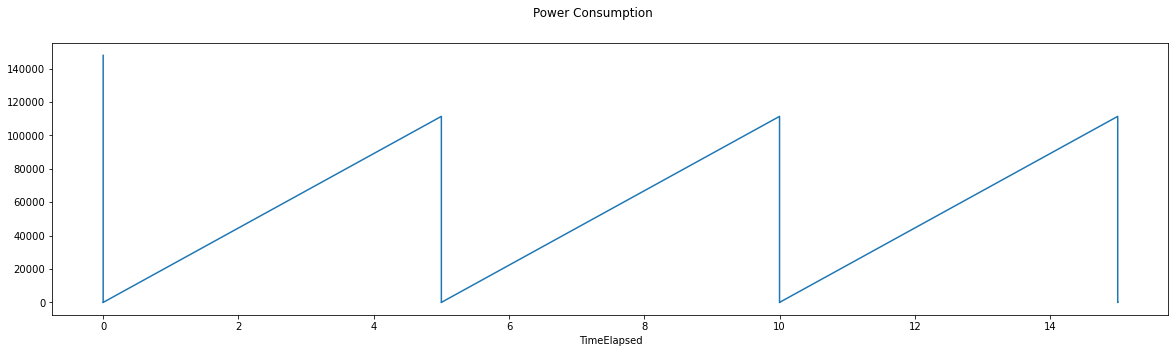

In [17]:
filename = "ElectionData.csv"
dt_col = "time"
val_col = "Votes"
val_dsg = "Power Consumption"
df_sz = 1500
df = pd.read_csv(filename, header=0, index_col=0, parse_dates=[dt_col]).head(df_sz)
print(df.info())
fig = plt.figure()
fig.suptitle(val_dsg)
df[val_col].plot()

STEP 1: Try to guess the duration of the seasonal component in your data.

STEP 2: Now run a 24 hours centered moving average on the data. The 24 hours centered MA is an average of two moving averages that are shifted from each other by 1 month, effectively making it a weighted moving average.

In [18]:
t_col = 'TREND'

# Add an empty column to store the centered MA values
df[t_col] = np.nan
 
# Fill it up with the centered MA values with 24h of 10 min each observation
ss = 24 * 6
for i in range(ss,df[val_col].size-ss):
    vv = (df[val_col][i - ss]+df[val_col][i + ss]) * 1.0 / (4*ss) + df[val_col][i] * 1.0 / (2*ss)
    for j in range(1,ss):
        vv += (df[val_col][i - j]+df[val_col][i + j]) * 1.0 / (2*ss)
    df[t_col][i] = np.round(vv)
df = df.iloc[ss: , :]
df = df.iloc[:(df.shape[0]-ss), :]
fig = plt.figure()
fig.suptitle(val_dsg+' '+t_col)
df[t_col].plot()

KeyError: 288

STEP 3: Now we have a decision to make. Depending on whether the composition is multiplicative or additive, we’ll need to divide or subtract the trend component from the original time series to retrieve the seasonal and noise components. 
- If we inspect the original time series and see that the seasonal swings are increasing in proportion to the current value of the time series, we ahould assume that the seasonality is multiplicative.
- Otherwise we may assume that it is additive.

<AxesSubplot:xlabel='DateTime'>

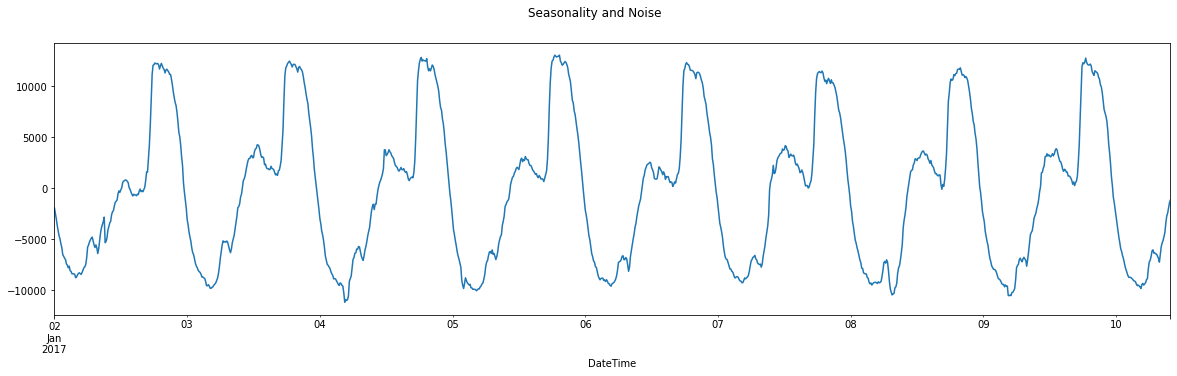

In [10]:
sn_col = 'SEASONALITY and NOISE'
TStype = 'additive' #'multiplicative'  # 
if (TStype=='additive'):
    df[sn_col] = df[val_col]-df[t_col]
else:
    df[sn_col] = df[val_col]/df[t_col]
fig = plt.figure()
fig.suptitle('Seasonality and Noise')
df[sn_col].plot()

STEP 4: Next, we will get the ‘pure’ seasonal component out of the mixture of seasonality and noise, by calculating the average value of the seasonal component for all values by "day".

<ipython-input-11-88fff4a2f966>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df[ss_col] = df.index.strftime('%H').astype(np.int)*60 + df.index.strftime('%M').astype(np.int)
<ipython-input-11-88fff4a2f966>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[s_col][i] = average_seasonal_values[df[ss_col][i]]


                     HOUR-MINUTES
DateTime                         
2017-01-02 00:00:00             0
2017-01-02 00:10:00            10
2017-01-02 00:20:00            20
2017-01-02 00:30:00            30
2017-01-02 00:40:00            40
2017-01-02 00:50:00            50
2017-01-02 01:00:00            60
2017-01-02 01:10:00            70


<AxesSubplot:xlabel='DateTime'>

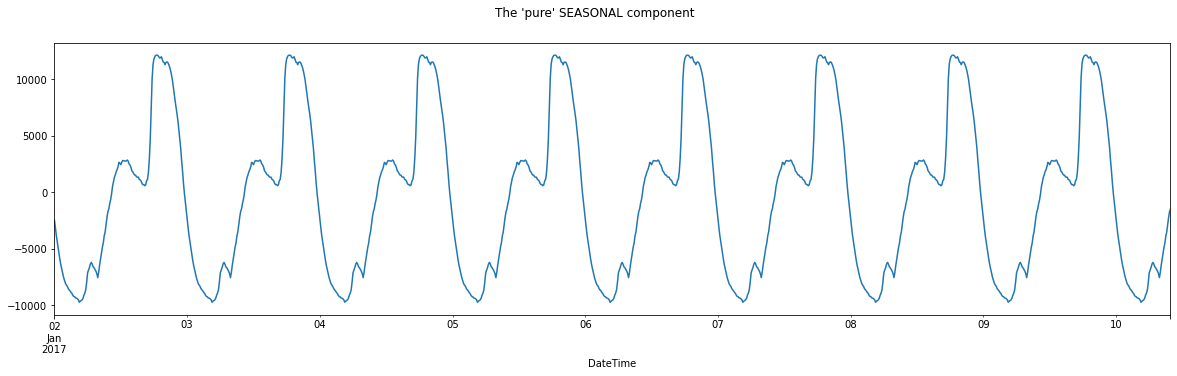

In [11]:
s_col = 'SEASONALITY'

# first add a minutes column
ss_col = 'HOUR-MINUTES'
df[ss_col] = df.index.strftime('%H').astype(np.int)*60 + df.index.strftime('%M').astype(np.int)
ss_min = int(min(list(df[ss_col].unique())))
ss_max = int(max(list(df[ss_col].unique())))
print(df[[ss_col]].head(8))

# initialize the day based dictionaries to store the running total of the minutes wise seasonal sums and counts
average_seasonal_values = {}
average_seasonal_value_counts = {}
for i in range(ss_min,ss_max+1):
    average_seasonal_values[i] = 0
    average_seasonal_value_counts[i] = 0 

# calculate the sums and counts
for i in range(0, df[sn_col].size):
    val1 = df[sn_col][i]
    val2 = df[ss_col][i]
    if math.isnan(val1) is False:
        average_seasonal_values[val2] = average_seasonal_values[val2] + val1
        average_seasonal_value_counts[val2] = average_seasonal_value_counts[val2] + 1

# calculate the average seasonal component for each day
for i in range(ss_min, ss_max+1):
    if (average_seasonal_value_counts[i]>0):
        average_seasonal_values[i] = average_seasonal_values[i] / average_seasonal_value_counts[i]

#create a new column in the data frame and fill it with the value of the average seasonal component for the corresponding minutes
df[s_col] = np.nan
for i in range(0, df[sn_col].size):
    if math.isnan(df[sn_col][i]) is False:
        df[s_col][i] = average_seasonal_values[df[ss_col][i]]
    else:
        print('nan')
fig = plt.figure()
fig.suptitle('The \'pure\' SEASONAL component') 
df[s_col].plot()

STEP 5: Finally, calculate the noisy component.

<AxesSubplot:xlabel='DateTime'>

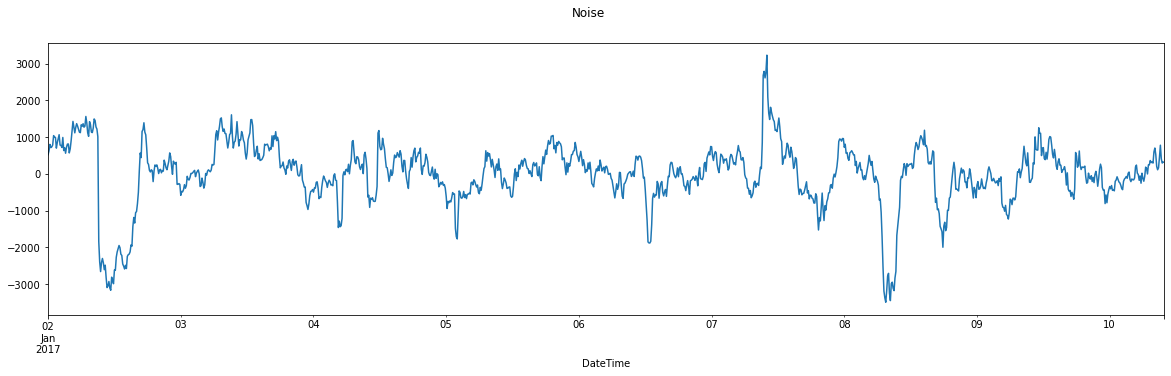

In [12]:
n_col = 'NOISE'
if (TStype=='additive'):
    df[n_col] = df[sn_col]-df[s_col]
else:
    df[n_col] =  df[sn_col]/df[s_col]
fig = plt.figure()
fig.suptitle('Noise')
df[n_col].plot()